# Introdução às Redes Neurais Fisicamente Informadas - PINNs (Dia 06) Picture1.jpg

---
**Objetivo deste notebook:** resolver dois problemas envolvendos equações parciais escalares. Um problema de Cauchy (KdV) e um problema de contorno (Poisson). Veremos como tratar cada um dos casos detalhadamente.


---
### EXEMPLO 7

**Objetivo:** Neste exemplo vamos resolver a equação de Poisson $$u_{xx}-2\cos(\beta)u_{xy}+u_{yy}=-\sin^2(\beta)$$ no quadrado $[-1,1]\times[-1,1]$ com condições de contorno $u(x,-1)=u(x,1)=u(-1,y)=u(1,y)=0.$

*Referência: Silva, V. C. ESCOAMENTO DE POISEUILLE
EM UM DUTO LOSANGULAR. Trabalho de Conclusão de Curso, Departamento de Engenharia Mecânica, UnB, 2023.*


---
Começamos instalando a biblioteca DeepXDE

In [ ]:
!pip install deepxde -q gwpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.7/183.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.4 MB/s eta 0:00:00


---
Importando e definindo o necessário. *Backend* utilizado é o Pytorch.

*Obs.: Desde a última atualização do DeepXDE (1.12.0) o L-BFGS não está funcionando adequadamente com o Tensorflow v1 e v2. Use o Pytorch ou PaddlePaddle como *backend*. Para detalhes de como instalar o PaddlePaddle veja os exemplos 9 e 10.*

In [ ]:
# Troca o backend para o Pytorch
import os
os.environ['DDE_BACKEND'] = 'pytorch'

import deepxde as dde

# Troca o tipo de ponto flutuante para 64 bit, originalmente é 32 bit (essa alteração é necessária)
dde.config.set_default_float('float64')

import numpy as np

import torch

# definindo a versao pytorch do seno e cosseno necessária pra equação
sin = torch.sin
cos = torch.cos

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64


---
**1$^\mathrm{a}$ Etapa**

Começamos definindo a função `pde` com duas entradas: (1) a variável independente `x` e (2) a variável dependente `y`. Porém, diferentemente dos casos em que tratamos as EDOs, aqui a variável `x` é um vetor com duas entradas $x=(x_0,x_1).$

Para escrevemos a equação diferencial precisamos das derivadas de segunda ordem da variável dependente. Como vimos a 2$^\mathrm{a}$ derivada é calculada utilizando o comando `dde.grad.hessian(y, x)`, porém como `x` é um vetor precisamos indicar quais os índices das derivadas, por exemplo, aqui temos:
* `dde.grad.hessian(y, x, i=0, j=0)` retorna $u_{xx}$
* `dde.grad.hessian(y, x, i=0, j=1)` retorna $u_{xy}$
* `dde.grad.hessian(y, x, i=1, j=1)` retorna $u_{yy}$


In [ ]:
# precisa converter a constante pi/8 para o formato de tensor, já que ela vai ser passada pro sin e cos
beta = torch.tensor(np.pi/8)

def pde(x, y):

    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_xy = dde.grad.hessian(y, x, i=0, j=1)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)

    return  dy_xx - 2*cos(beta)*dy_xy + dy_yy + sin(beta)**2

---
**2$^\mathrm{a}$ Etapa**

Vamos agora definir a geometria do nosso domínio que é o quadrado $[-1,1]\times[-1,1]$.

O DeepXDE já tem um módulo específico para criar um domínio retangular que é `dde.geometry.Rectangle([a,b], [c,d])`, sendo que `[a,b]` representa o vértice inferior esquerdo e `[c,d]` o vértice superior direito.

Uma novidade neste caso é o uso da condição de contorno de Dirichlet que define $u(a,t)=g_1(t)$ e $u(b,t)=g_2(t)$. Para definirmos as funções de perda relacionas a esses valores utilizamos a função `dde.icbc.DirichletBC(...)`.

Ela faz parte do módulo de condições iniciais e de fronteira do DeepXDE e suas entradas são: (1) a geometria; (2) a condição de fronteira no, caso $u|_{\partial R}=0,$ e (3) a função que retorna se o ponto está ou não na fronteira: `lambda _, on_boundary: on_boundary`.

In [ ]:
# constrói a geometria: R=[-1,1]^2
geom = dde.geometry.Rectangle([-1, -1], [1, 1])

# Definindo o contorno como as quatro fronteiras do quadrado [-1,1]^2
bc = dde.icbc.DirichletBC(geom, lambda x: 0, lambda _, on_boundary: on_boundary)

---
**3$^\mathrm{a}$ Etapa**

Montamos agora a estrutura da nossa rede neural.

Primeiro passo é utilizar o método `PDE` para incluir as informações que definimos no passo anterior: (1) geometria; (2) equação diferencial; (3) condições de contorno; (4) a quantidade de pontos amostrados aleatoriamente no interior do domínio; (5) quantidade de pontos amostrados na fronteira e (6) a quantidade de pontos de teste.

Em seguida devemos escolher os parâmetros da rede como: (1) número de camadas e neurônios, (2) função de ativação e (3) o inicializador dos pesos.

Continuamos usando o`ADAM` como otimizador para o cálculo dos parâmetros treináveis da rede.

Por último compilamos o modelo para fazer a mágica acontecer.

Compiling model...
'compile' took 0.000433 s

Training model...

Step      Train loss              Test loss               Test metric
0         [5.51e-02, 2.19e-01]    [5.17e-02, 2.19e-01]    []  
1000      [6.35e-06, 8.37e-05]    [4.42e-06, 8.37e-05]    []  
2000      [6.91e-06, 5.07e-05]    [4.98e-06, 5.07e-05]    []  
3000      [1.34e-05, 1.75e-05]    [1.08e-05, 1.75e-05]    []  
4000      [7.32e-06, 9.75e-06]    [6.14e-06, 9.75e-06]    []  
5000      [7.12e-06, 2.33e-04]    [5.91e-06, 2.33e-04]    []  
6000      [2.92e-06, 5.55e-06]    [1.82e-06, 5.55e-06]    []  
7000      [4.77e-06, 3.74e-05]    [4.04e-06, 3.74e-05]    []  
8000      [2.02e-06, 4.93e-06]    [1.23e-06, 4.93e-06]    []  
9000      [1.96e-06, 4.41e-06]    [1.33e-06, 4.41e-06]    []  
10000     [1.71e-06, 1.47e-05]    [1.15e-06, 1.47e-05]    []  

Best model at step 9000:
  train loss: 6.37e-06
  test loss: 5.74e-06
  test metric: []

'train' took 125.774531 s

Compiling model...
'compile' took 0.001173 s

Training 

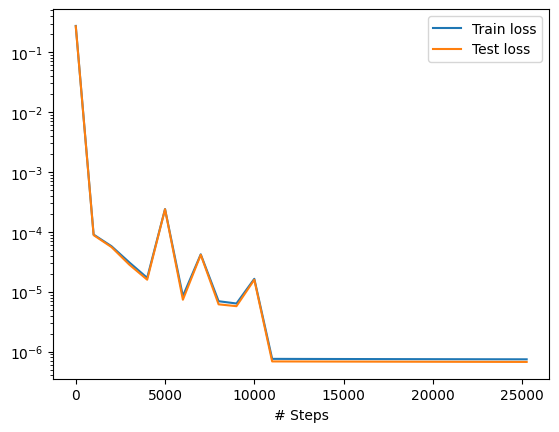

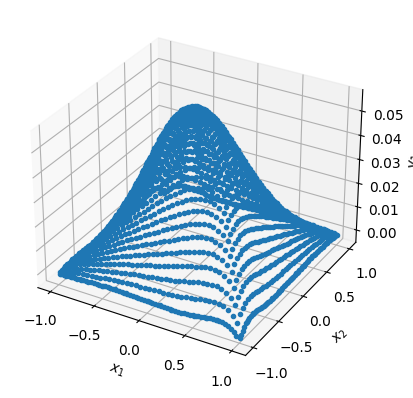

In [ ]:
# constrói o modelo
data = dde.data.PDE(geom, pde, bc, num_domain=1200, num_boundary=300, num_test=1500)
net = dde.nn.FNN([2] + [60] * 4 + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

# a compilação usando adam e depois l-bfgs é para aumentar a precisão
model.compile("adam", lr=0.001)
model.train(iterations=10000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

---
**4$^\mathrm{a}$ Etapa**

Finalmente, imprimimos a solução calculada.

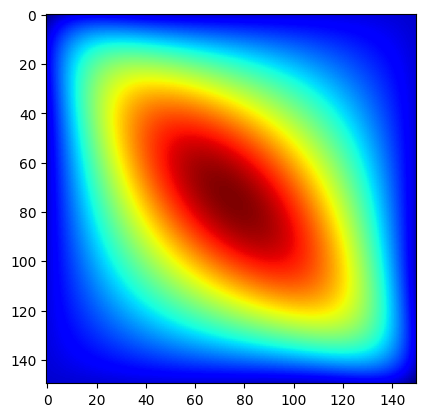

In [ ]:
# imprime a solução como um mapa de calor
import matplotlib.pyplot as plt
import numpy as np

nop = 150

Nx = nop
Ny = nop

# monta o grid
xmin, xmax, ymin, ymax = [-1, 1, -1, 1]
plot_grid = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]
points = np.vstack(
    (plot_grid[0].ravel(), plot_grid[1].ravel(), np.zeros(plot_grid[0].size))
)

# aplica os pontos do grid no modelo
points_2d = points[:2, :]
u = model.predict(points[:2, :].T)
u = u.reshape((Nx, Nx))
matrix = np.fliplr(u).T

# imprime o bicho
plt.imshow(matrix, cmap='jet')
plt.show()

---
### EXEMPLO 8

**Objetivo:** Neste exemplo vamos resolver um problema de Cauchy com a equação KdV $$u_t-\frac{3}{2}u u_x -\frac{1}{6} u_{xxx}=0$$ com condição inicial $u(x,0)=A \mathrm{sech}^2(kx),$ para $A=0.5$ e $k=\frac{1}{2}\sqrt{3A}.$ Nessas condições a solução da equação é uma onda viajante $u(x,t)=A\mathrm{sech}^2(k(x+\frac{A}{2}t)$.

*Referência: Vasconcelos, M. V. F., Ribeiro-Jr, Roberto. Solitary water wave interactions for the forced Korteweg-de Vries equation. Computational and Applied Mathematics, v. 40, p. 1, 2021.*


---
**1$^\mathrm{a}$ Etapa**

Começamos definindo a função `pde` novamente com duas entradas: (1) a variável independente `x` e (2) a variável dependente `y`. Porém, diferentemente do caso anterior, aqui a variável `x` é um vetor com duas entradas $x=(s,t),$ espaço e tempo, respectivamente.

Nos casos anteriores que trabalhamos com a primeira derivada a função tinha apenas uma variável. Nesta situação em que a função tem duas, no `dde.grad.jacobian(...)` é preciso indicar o índice das variáveis, além disso é preciso indicar qual componente da função está sendo derivada. Como a função é escalar o índice da componente é `i=0`.

Finalmente, para calcular a terceira derivada que aparece na equação simplesmente derivamos a derivada de $x$ mais duas vezes com o `dde.grad.hessian(...)`.


In [ ]:
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0) # dy_0/dx_0 = dy/dx
    dy_t = dde.grad.jacobian(y, x, i=0, j=1) # dy_0/dx_1 = dy/dt
    dy_xxx = dde.grad.hessian(dy_x, x, i=0, j=0) #cálculo da 3a derivada!
    return dy_t - (3/2) * y * dy_x - (1/6)* dy_xxx

---
Como uma novidade nesta situação é uma equação parcial que depende do tempo, precisamos definir a nossa geometria baseada em dois intervalos: um para $x$ e um para $t$. Fazemos isso de forma separada com os módulos `dde.geometry.Interval(a,b)` e `dde.geometry.TimeDomain(t1,t2)`. Em seguida precisamos unir essas duas geometrias utilizando o módulo `dde.geometry.GeometryXTime(geometria1,geometria2)`.



In [ ]:
xmin = -10
xmax = 10
tmin = 0
tmax = 3

geom = dde.geometry.Interval(xmin, xmax) # variável espacial
timedomain = dde.geometry.TimeDomain(tmin, tmax) # variável temporal
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# observe que estamos definindo a condição inicial diretamente dentro da função dde.icbc.IC(...)
A = 1
k = np.sqrt(3*A/4)
ic = dde.icbc.IC(geomtime, lambda x: A*(1/np.cosh(k*x[:, 0:1])**2), lambda _, on_initial: on_initial)

---
**3$^\mathrm{a}$ Etapa**

Montamos agora a estrutura da nossa rede neural com a diferença que iremos utilizar o método `TimePDE(...)` e compilamos utilizando o `ADAM`.

Compiling model...
'compile' took 0.000459 s

Training model...

Step      Train loss              Test loss               Test metric
0         [3.58e-03, 3.42e-01]    [3.58e-03, 3.42e-01]    []  
1000      [4.79e-04, 2.24e-04]    [4.79e-04, 2.24e-04]    []  
2000      [1.25e-04, 1.73e-05]    [1.25e-04, 1.73e-05]    []  
3000      [4.49e-05, 5.89e-06]    [4.49e-05, 5.89e-06]    []  
4000      [1.69e-05, 1.81e-06]    [1.69e-05, 1.81e-06]    []  
5000      [7.86e-06, 7.12e-07]    [7.86e-06, 7.12e-07]    []  
6000      [4.51e-06, 9.55e-07]    [4.51e-06, 9.55e-07]    []  
7000      [2.73e-06, 2.86e-07]    [2.73e-06, 2.86e-07]    []  
8000      [1.78e-06, 2.18e-06]    [1.78e-06, 2.18e-06]    []  
9000      [1.11e-06, 1.42e-07]    [1.11e-06, 1.42e-07]    []  
10000     [7.26e-07, 1.04e-07]    [7.26e-07, 1.04e-07]    []  
11000     [4.86e-07, 1.05e-07]    [4.86e-07, 1.05e-07]    []  
12000     [3.48e-07, 4.73e-07]    [3.48e-07, 4.73e-07]    []  
13000     [2.41e-07, 6.26e-08]    [2.41e-07, 6

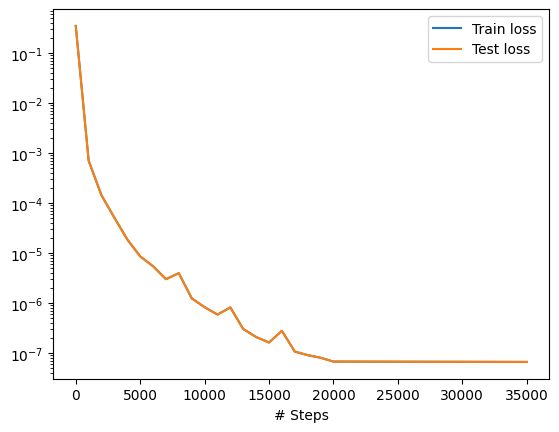

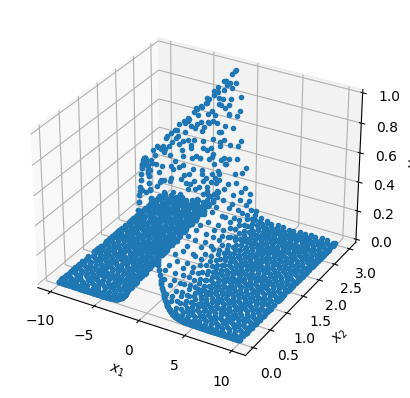

In [ ]:
data = dde.data.TimePDE(geomtime, pde, [ic], num_domain=1500, num_boundary=150, num_initial=320)
net = dde.nn.FNN([2] + [80] * 4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-4)
model.train(iterations=20000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

---
**4$^\mathrm{a}$ Etapa**

Finalmente, imprimimos a solução calculada.

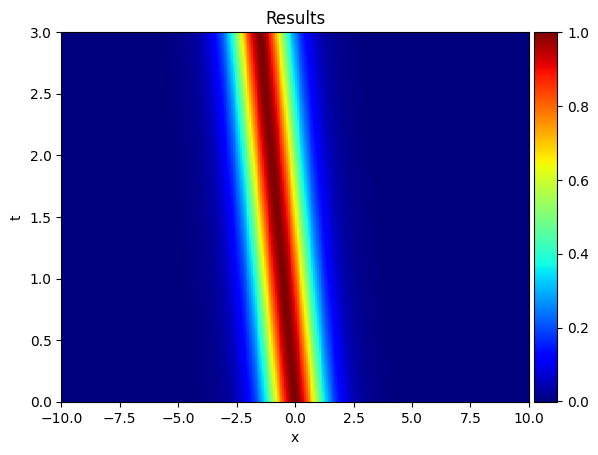

In [ ]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


x = np.linspace(-10, 10, 256)
t = np.linspace(0, 3, 256)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
prediction = model.predict(X_star, operator=None)

v = griddata(X_star, prediction[:, 0], (X, T), method="cubic")

fig, ax = plt.subplots()
ax.set_title("Results")
ax.set_ylabel("t")
ax.set_xlabel("x")
im = ax.imshow(
    v,
    interpolation="nearest",
    cmap="jet",
    extent=[-10, 10, 0, 3],
    origin="lower",
    aspect="auto",
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()